In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import unet
from unet import utils
from unet.datasets import circles
import os
import glob
import matplotlib.pyplot as plt

In [2]:
# This block is needed for my system. 

import keras

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.compat.v1.Session(config=config)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
import PIL
import PIL.Image
import pathlib
from PIL import Image

In [4]:
image_path = "data/BBBC004_v1_000_images/synthetic_000_images/"
label_path = "data/BBBC004_v1_000_foreground/synthetic_000_foreground/"

file_extension = "tif"

inp_dim = 200
prediction_tau = 6

file_names = (glob.glob(image_path + "*." + file_extension))
file_names_labels = (glob.glob(label_path + "*." + file_extension))

images = []
for file in file_names:
    if file_extension == "tif":
        # dat = np.expand_dims(plt.imread(file), axis=2)
        images.append(tf.convert_to_tensor( np.expand_dims(plt.imread(file), axis=2 ) )) # For .tif
        images[-1] = images[-1] / 255 # Normalize
        images[-1] = tf.image.resize(images[-1], [inp_dim,inp_dim], preserve_aspect_ratio=True, method='bilinear')
    elif file_extension == "png":
        images.append(tf.convert_to_tensor(plt.imread(file)[:,:,:3] )) # For .png
        images[-1] = tf.image.resize(images[-1], [inp_dim,inp_dim], preserve_aspect_ratio=True, method='bilinear')
        images[-1] = tf.image.rgb_to_grayscale(images[-1])
    
    
labels = []
for file in file_names_labels:
    #label = plt.imread(file)[:,:,2:3]
    label = plt.imread(file)[:,:,:3]
    label = (np.expand_dims(np.sum(label, axis=2), axis=2))
    #label = Image.open(file).convert('LA')
    #label.resize((200, 200))
    #label = np.asarray(label)
    #label2 = label
    #print(label.shape)
    #print(np.max(label))
    
    label = np.where(label > 0, [0, 1], [1, 0])
    labels.append(tf.convert_to_tensor(label))
    
    labels[-1] = tf.image.resize(labels[-1], [inp_dim,inp_dim], preserve_aspect_ratio=True, method='bilinear')
    label[-1] = np.where(label[-1] > 0.5, 1, 0)

    #labels[-1] = tf.image.rgb_to_grayscale(labels[-1])

image_dataset = tf.data.Dataset.from_tensor_slices((images, labels))


In [5]:
print(circles.channels)
print(circles.classes)

unet_model = unet.build_model(channels=circles.channels,
                              num_classes=circles.classes,
                              layer_depth=3,
                              filters_root=16)
unet.finalize_model(unet_model)

1
2


In [6]:
@tf.function
def load_image_train(input_image, input_mask):
  #input_image = datapoint[0]
  #input_mask = datapoint[1]

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
      
    

  return input_image, input_mask


In [7]:
train_dataset, validation_dataset = circles.load_data(100, nx=inp_dim, ny=inp_dim, splits=(0.7, 0.3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

train_dataset = image_dataset.take(15)
validation_dataset = image_dataset.skip(15)

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(load_image_train)

In [8]:
trainer = unet.Trainer(checkpoint_callback=False)
trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=50,
            batch_size=1)

Epoch 1/50
15/15 [==============================] - 3s 187ms/step - loss: 0.5520 - categorical_crossentropy: 0.5520 - categorical_accuracy: 0.8427 - mean_iou: 0.3499 - dice_coefficient: 0.6307 - auc: 0.8335 - val_loss: 0.5438 - val_categorical_crossentropy: 0.5438 - val_categorical_accuracy: 0.8958 - val_mean_iou: 0.3265 - val_dice_coefficient: 0.5908 - val_auc: 0.8157 - learning_rate: 0.0010
Epoch 2/50
15/15 [=========================

In [9]:
prediction = unet_model.predict(validation_dataset.batch(batch_size=3))

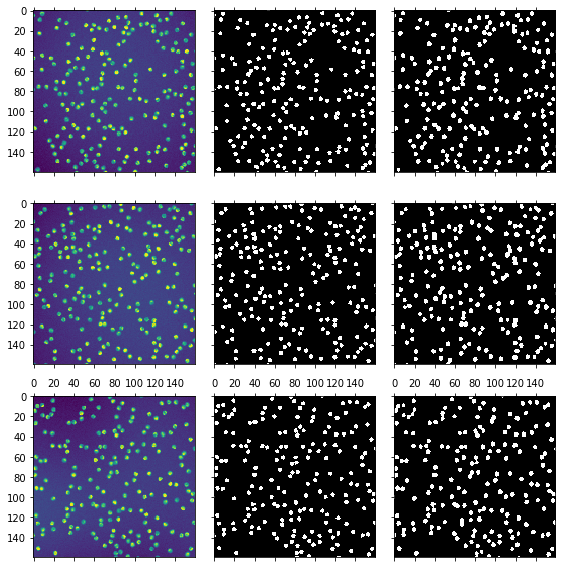

In [10]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1])
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray)
    # ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray)
    ax[i][2].matshow(np.argmax(prediction[i,...] * np.array([[[1, prediction_tau]]]), axis=-1), cmap=plt.cm.gray)

# tf.print()
plt.tight_layout()

In [11]:
prediction2 = unet_model.predict(image_dataset.batch(batch_size=1))

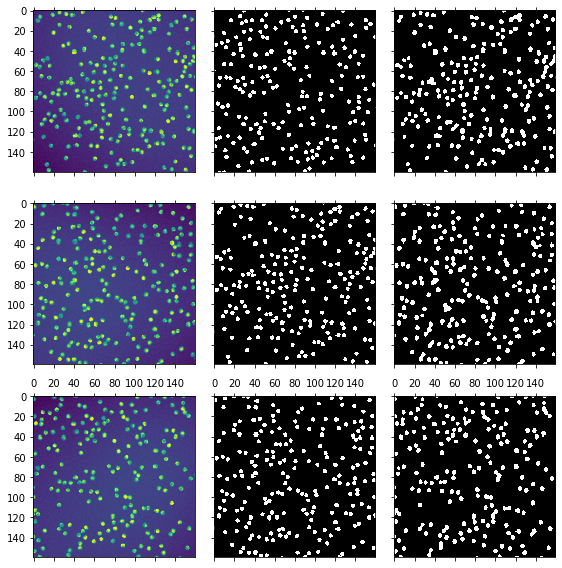

In [14]:
# Investigate Bug here where the labels for the images are shifted one step 
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))
dataset = image_dataset.map(utils.crop_image_and_label_to_shape(prediction2.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1])
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray)
    # ax[i][2].matshow(np.argmax(prediction2[i,...], axis=-1), cmap=plt.cm.gray)
    ax[i][2].matshow(np.argmax(prediction2[i,...] * np.array([[[1, prediction_tau]]]), axis=-1), cmap=plt.cm.gray)


# tf.print()
plt.tight_layout()



